This notebook shows how the explainability graphs were created, see explainability

In [1]:
global _debug
_debug = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from pathlib import Path

from gym_power_trading.envs import PowerTradingEnv
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

sns.set_theme()

### Formatting function for plot axes

In [3]:
def format_axis_commas(ax, axis):
    """
    Formats the y-axis tick labels to 
    include commas as thousands separators.
    """
    if axis == 'y':
        formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")
        ax.yaxis.set_major_formatter(formatter)
    elif axis == 'x':
        formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")
        ax.xaxis.set_major_formatter(formatter)

#### Callback for logging rewards across parallel environments during Agent training

In [4]:
class VecRewardLogger(BaseCallback):
    """
    Callback for tracking Agent reward progress across training Epochs
    """
    def __init__(self, verbose=0):
        # Reward logging init
        super(VecRewardLogger, self).__init__(verbose)
        self.rewards = []
        self.episode_rewards = None
    
    def _on_training_start(self):
        # Initialize on training start to get the number of environments
        self.episode_rewards = np.zeros(self.model.env.num_envs)

    def _on_step(self) -> bool:
        """ This method is called after each step """
        # Update rewards for all environments
        self.episode_rewards += np.array(self.locals['rewards'])
        # Check if any episode is done
        if np.any(self.locals['dones']):
            avg_episode_reward = np.mean(self.episode_rewards)
            self.rewards.append(avg_episode_reward)
            if self.verbose > 0:
                print("Logged rewards for completed episodes:", [self.rewards[-1]])
        return True  # Always return True to continue training

### Callback for setting learning rate schedule across Epochs

In [5]:
class LearningRateScheduler(BaseCallback):
    """
    Callback for setting agent learning rate schedule across trainig Epochs
    """
    def __init__(self, initial_rate, schedule_func, total_timesteps, epoch_timesteps, verbose=0):
        # LR schedule init
        super(LearningRateScheduler, self).__init__(verbose)
        self.initial_learning_rate = initial_rate
        self.schedule_func = schedule_func
        self.total_timesteps = total_timesteps
        self.epoch_timesteps = epoch_timesteps
    
    def _on_training_start(self):
        # Initialize LR
        self.model.policy.optimizer.param_groups[0]['lr'] = self.initial_learning_rate
    
    def _on_step(self) -> bool:
        # Update LR based on schedule function
        total_steps = self.num_timesteps + self.model._num_timesteps_at_start
        epoch = total_steps // self.epoch_timesteps
        updated_lr = self.schedule_func(epoch)
        self.model.policy.optimizer.param_groups[0]['lr'] = updated_lr
        return True

In [6]:
def exponential_schedule(initial_lr, decay_rate):
    """
    Exponential decay learning rate schedule.
    Parameters:
        initial_lr (float): The initial learning rate.
        decay_rate (float): The rate of decay, larger values mean more decay.
    Returns: 
        func (object): Function to compute the lr given the fraction of the training completed.
    """
    def func(epoch):
        return initial_lr * np.exp((-decay_rate * epoch))
    return func

In [7]:
file_name = "data\AEP_PSGC1_AMP_dart_Oct20.h5"
path = Path(file_name).resolve()
path_string = str(path)
df = pd.read_hdf(path_string)
df.head()

RT_LMP  DA_LMP
MARKET_DAY NODE          TYPE    VALUE HourEnding                
2020-10-01 AEP.PSGC1.AMP Gennode LMP   1            10.02   14.33
                                       2            12.51   13.09
                                       3            12.79   12.96
                                       4            12.53   13.62
                                       5            13.43   14.49

## PPO Agent with Basic Features 

### (4-hr Observation Window, 500,000 training iterations) 

Environment Observation Comprised of:
-  Current Price (\$/Mwh) / DA Price \($/Mwh)
-  Price Difference (from last tick) (%)
-  Battery State of Charge (%)
-  Battery Avg Energy Price (\$/Mwh) / Battery Avg Energy Price Window-period Rolling Avg \($/Mwh)



Rewards: 

    - Log Return of profitable discharges: Revenue / Power Sold * Stored Power Cost Basis
    - Log of revenue when selling power with negative cost basis: ln(revenue + |Stored Power Cost Basis|)

Penalty:

    - Overcharging (-1)
    - Discharging When Empty (-1)
    - Losing Money (-2)

In [8]:
%%time
TOTAL_TIMESTEPS = 500_000
VAL_SIZE = 3000
TRAIN_WINDOW = 720 # hrs (1 month)
WINDOW = 4 # hours
N_ENVS = 4

# Walk forward during training to simulate real environment + reduce agent memorization
num_batches = (df.shape[0] - VAL_SIZE) // TRAIN_WINDOW
batch_timesteps = (TRAIN_WINDOW - WINDOW - 1) * N_ENVS
epoch_timesteps = (num_batches * batch_timesteps)
num_epochs = TOTAL_TIMESTEPS // epoch_timesteps

LR_INITIAL = 5E-4
DECAY_RATE = 0.97
lr_schedule = exponential_schedule(LR_INITIAL, DECAY_RATE)

lr_callback = LearningRateScheduler(LR_INITIAL, lr_schedule, TOTAL_TIMESTEPS, epoch_timesteps)
reward_callback = VecRewardLogger(verbose=1)

# Produce Observations across # n_envs parallel environments 
venv = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=WINDOW, frame_bound=(0, TRAIN_WINDOW)), n_envs=N_ENVS) 
PPO_power_basic = PPO('MlpPolicy', venv, device='cpu', learning_rate=LR_INITIAL, normalize_advantage=True)


c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:205: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Change from price 1-tick ago


CPU times: total: 906 ms
Wall time: 1.7 s


In [19]:
%%time
TOTAL_TIMESTEPS = 500_000
VAL_SIZE = 3000
TRAIN_WINDOW = 720 # hrs (1 month)
WINDOW = 4 # hours
N_ENVS = 4

# Walk forward during training to simulate real environment + reduce agent memorization
num_batches = (df.shape[0] - VAL_SIZE) // TRAIN_WINDOW
batch_timesteps = (TRAIN_WINDOW - WINDOW - 1) * N_ENVS
epoch_timesteps = (num_batches * batch_timesteps)
num_epochs = TOTAL_TIMESTEPS // epoch_timesteps

LR_INITIAL = 5E-4
DECAY_RATE = 0.97
lr_schedule = exponential_schedule(LR_INITIAL, DECAY_RATE)

lr_callback = LearningRateScheduler(LR_INITIAL, lr_schedule, TOTAL_TIMESTEPS, epoch_timesteps)
reward_callback = VecRewardLogger(verbose=1)

# Produce Observations across # n_envs parallel environments 
venv = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=WINDOW, frame_bound=(0, TRAIN_WINDOW)), n_envs=N_ENVS) 
PPO_power_basic = PPO('MlpPolicy', venv, device='cpu', learning_rate=LR_INITIAL, normalize_advantage=True)

for epoch in range(num_epochs):
    for i in range(num_batches):
        start_day = i * TRAIN_WINDOW
        end_day = start_day + TRAIN_WINDOW
        venv.env_method('set_frame_bound', start_day, end_day) # Set venvs frame bounds
        # Learn on currrent minibatch
        PPO_power_basic.learn(total_timesteps=batch_timesteps, callback=[reward_callback, lr_callback], reset_num_timesteps=False)

c:\users\andrew deur\documents\nyu\ds-ga 3001 reinforcement learning\3001-rl-grid-battery-management-agent\gym-power-trading\gym_power_trading\envs\power_trading.py:205: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Change from price 1-tick ago
c:\Users\Andrew Deur\anaconda3\envs\rl_project\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [-116.98096098295487]
Logged rewards for completed episodes: [-237.17835183881016]
Logged rewards for completed episodes: [-69.20609494432574]
Logged rewards for completed episodes: [-149.37373719876632]
Logged rewards for completed episodes: [-57.12088560325907]
Logged rewards for completed episodes: [-110.31349434459825]
Logged rewards for completed episodes: [-41.22505086551038]
Logged rewards for completed episodes: [-89.72108638819529]
Logged rewards for completed episodes: [-32.797077885858016]
Logged rewards for completed episodes: [-64.64476270548766]
Logged rewards for completed episodes: [-16.682431894798356]
Logged rewards for completed episodes: [-42.036002757246024]
Logged rewards for completed episodes: [-24.557200790400223]
Logged rewards for completed episodes: [-42.37163636794398]
Logged rewards for completed episodes: [-18.771784237943322]
Logged rewards for completed episodes: [-37.083596872119344]
Logged rewards for completed e

### Episode Reward Progression

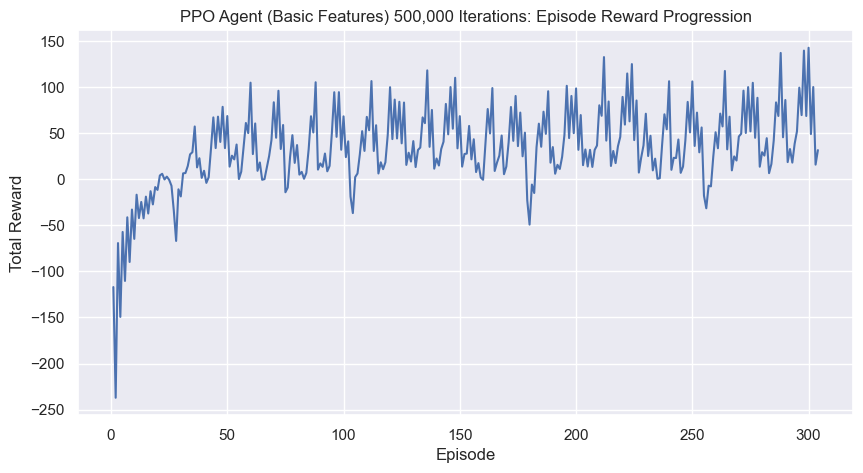

In [21]:
num_eps = np.arange(1, len(reward_callback.rewards) + 1)

fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'x')
ax.plot(num_eps, reward_callback.rewards)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Agent (Basic Features) 500,000 Iterations: Episode Reward Progression')
plt.show()

### Plot of Agent Trades in Held out test set

c:\users\chen5\rl-power-arbitrage-project\gym-power-trading\gym_power_trading\envs\power_trading.py:205: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Change from price 1-tick ago


[]

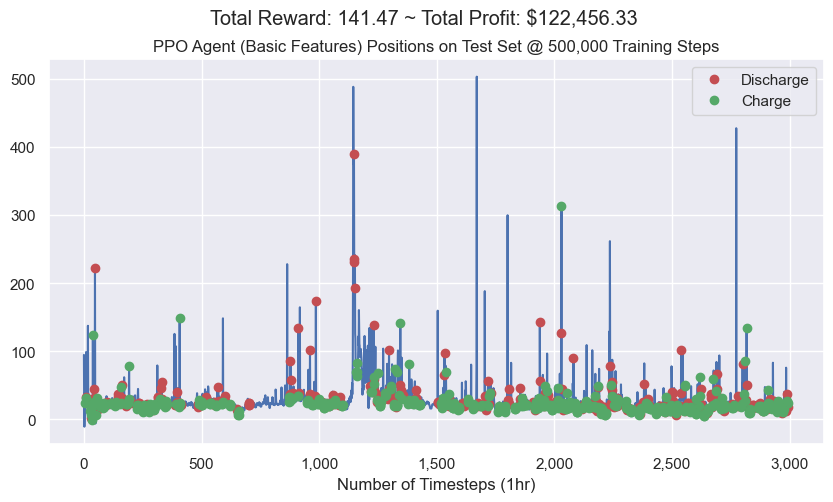

In [133]:
window = 4
last_index = len(df) - 10
start_index = last_index - VAL_SIZE
env = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_basic.predict(obs, deterministic=True)
    obs, rewards, term, trunc, info = env.step(action)
    if term or trunc:
        history = env.history
        env.render_all(title="PPO Agent (Basic Features) Positions on Test Set @ 500,000 Training Steps")
        env.reset()

plt.xlabel("Number of Timesteps (1hr)")
plt.plot()

In [10]:
PPO_power_basic = PPO.load("agents/PPO_power_basic_500k")


c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\chen5\miniforge3\envs\rl_proj2\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


# Explainability

[]

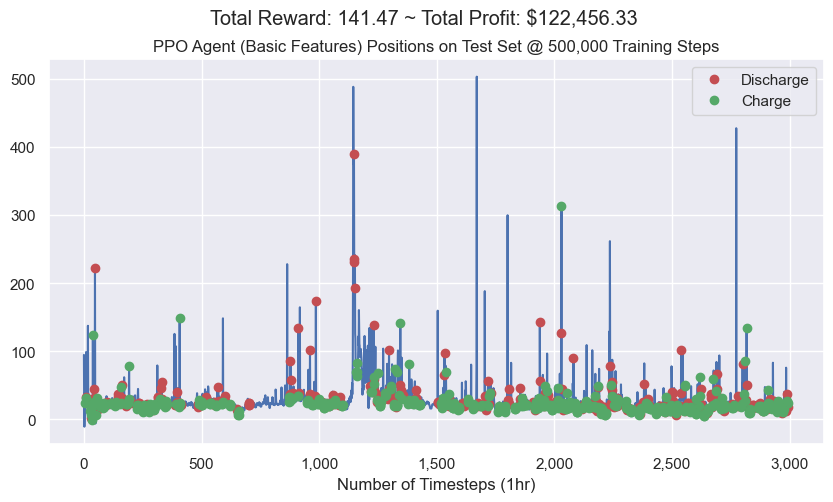

In [134]:
window = 4
last_index = len(df) - 10  # look at just the first quarter
start_index = last_index - VAL_SIZE
# last_index = start_index + VAL_SIZE//8
env = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env.reset()
obs = obs[0]
# store the actions taken for each observatoin
obs_list = []
action_list = []
for i in range(last_index - start_index):
    obs_list.append(obs)
    action, states = PPO_power_basic.predict(obs, deterministic=True)
    action_list.append(action)
    obs, rewards, term, trunc, info = env.step(action)
    if term or trunc:
        history = env.history
        env.render_all(title="PPO Agent (Basic Features) Positions on Test Set @ 500,000 Training Steps")
        env.reset()

plt.xlabel("Number of Timesteps (1hr)")
plt.plot()

In [135]:
obs_list[0]

array([4.5271555e-01, 3.7644342e-01, 0.0000000e+00, 0.0000000e+00,
       4.5292330e-01, 8.3892618e-04, 0.0000000e+00, 0.0000000e+00,
       4.9340934e-01, 1.6093881e-01, 0.0000000e+00, 0.0000000e+00,
       4.1133795e+00, 5.8368230e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [136]:
obs_list[0][12]
# 12 index corresponds to last prices_signal = prices / da_prices

4.1133795

In [137]:
len(obs_list)

3000

In [139]:
last_prices_signal = [i[12] for i in obs_list]

In [140]:
last_prices_signal = np.array(last_prices_signal)

In [141]:
last_pct_diff = [i[13] for i in obs_list]
last_pct_diff = np.array(last_pct_diff)

In [142]:
actions_array = np.array(action_list)

In [143]:
# Discharge = 0
# Charge = 1
# Hold = 2

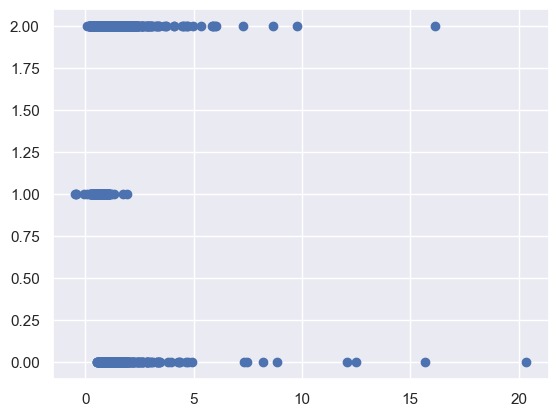

In [144]:
plt.scatter(last_prices_signal, actions_array)

(array([2.75e+03, 2.14e+02, 1.90e+01, 8.00e+00, 4.00e+00, 0.00e+00,
        2.00e+00, 2.00e+00, 0.00e+00, 1.00e+00]),
 array([-0.4463616 ,  1.63432217,  3.71500587,  5.79568958,  7.87637329,
         9.957057  , 12.03774071, 14.11842442, 16.19910812, 18.27979088,
        20.36047554]),
 <BarContainer object of 10 artists>)

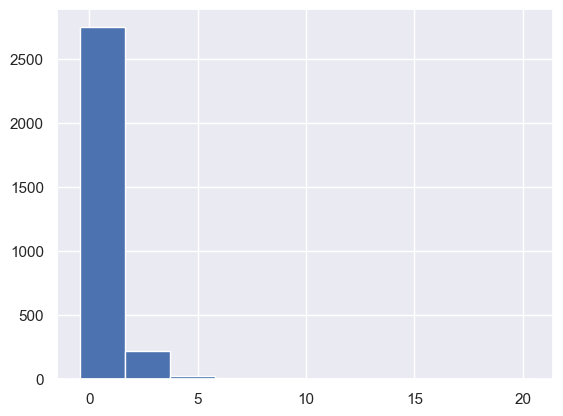

In [145]:
plt.hist(last_prices_signal)

In [146]:
from scipy import stats

In [147]:
# Discharge = 0
# Charge = 1
# Hold = 2

In [148]:
bin_percentile_size = .1
pDischarge, bin_edges, binnumber = stats.binned_statistic(last_prices_signal, actions_array ==0, statistic='mean',bins=np.quantile(last_prices_signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
pCharge, bin_edges, binnumber = stats.binned_statistic(last_prices_signal, actions_array ==1, statistic='mean',bins=np.quantile(last_prices_signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
pHold, bin_edges, binnumber = stats.binned_statistic(last_prices_signal, actions_array ==2, statistic='mean',bins=np.quantile(last_prices_signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog

In [149]:
np.quantile(last_prices_signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))

array([-0.4463616 ,  0.58161218,  0.68916585,  0.7703258 ,  0.84039999,
        0.91971943,  0.99676844,  1.07975301,  1.22427781,  1.53691558,
       20.36047554])

In [150]:
bin_edges

array([-0.4463616 ,  0.58161217,  0.68916583,  0.7703258 ,  0.8404    ,
        0.91971946,  0.9967684 ,  1.079753  ,  1.2242779 ,  1.5369155 ,
       20.360476  ], dtype=float32)

In [151]:
# Discharge = 0
# Charge = 1
# Hold = 2

Text(0, 0.5, 'Frequency of action')

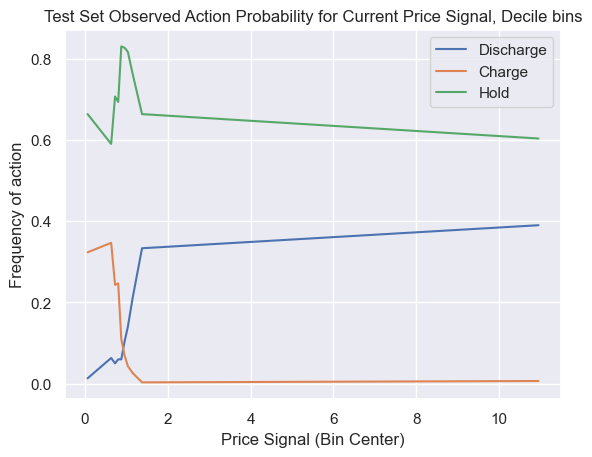

In [153]:
bin_width = (bin_edges[1:] - bin_edges[:-1])
bin_centers = bin_edges[1:] - bin_width/2

plt.plot(bin_centers,pDischarge, label = 'Discharge')
plt.plot(bin_centers,pCharge, label = 'Charge')
plt.plot(bin_centers,pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Price Signal, Decile bins")
plt.xlabel('Price Signal (Bin Center)')
plt.ylabel('Frequency of action')

Text(0, 0.5, 'Frequency of action')

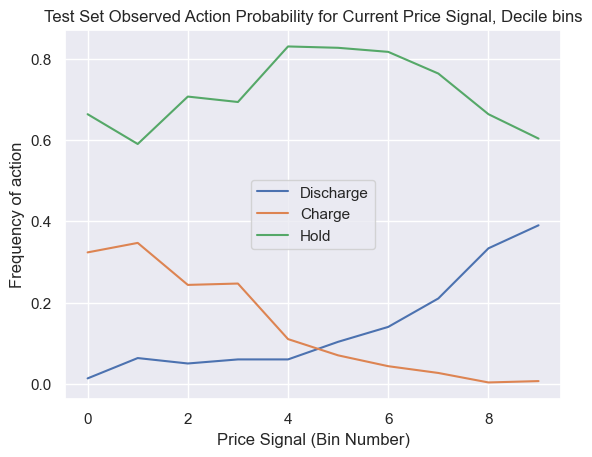

In [154]:
plt.plot(pDischarge, label = 'Discharge')
plt.plot(pCharge, label = 'Charge')
plt.plot(pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Price Signal, Decile bins")
plt.xlabel('Price Signal (Bin Number)')
plt.ylabel('Frequency of action')

Text(0, 0.5, 'Frequency of action')

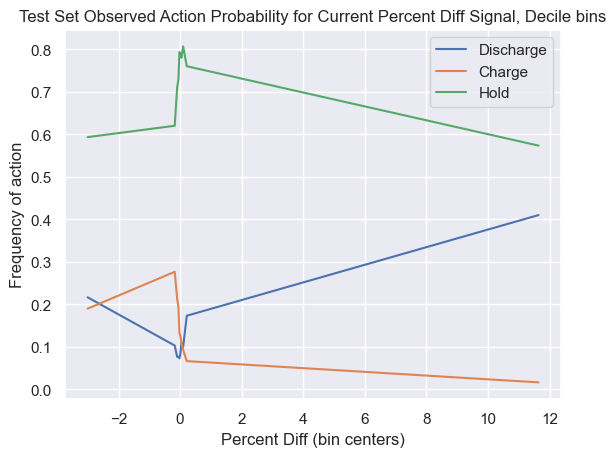

In [155]:
bin_percentile_size = .1
pDischarge, bin_edges, binnumber = stats.binned_statistic(last_pct_diff, actions_array ==0, statistic='mean',bins=np.quantile(last_pct_diff,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
pCharge, bin_edges, binnumber = stats.binned_statistic(last_pct_diff, actions_array ==1, statistic='mean',bins=np.quantile(last_pct_diff,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
pHold, bin_edges, binnumber = stats.binned_statistic(last_pct_diff, actions_array ==2, statistic='mean',bins=np.quantile(last_pct_diff,(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
bin_width = (bin_edges[1:] - bin_edges[:-1])
bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers,pDischarge, label = 'Discharge')
plt.plot(bin_centers,pCharge, label = 'Charge')
plt.plot(bin_centers,pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Percent Diff Signal, Decile bins")
plt.xlabel('Percent Diff (bin centers)')
plt.ylabel('Frequency of action')

Text(0, 0.5, 'Frequency of action')

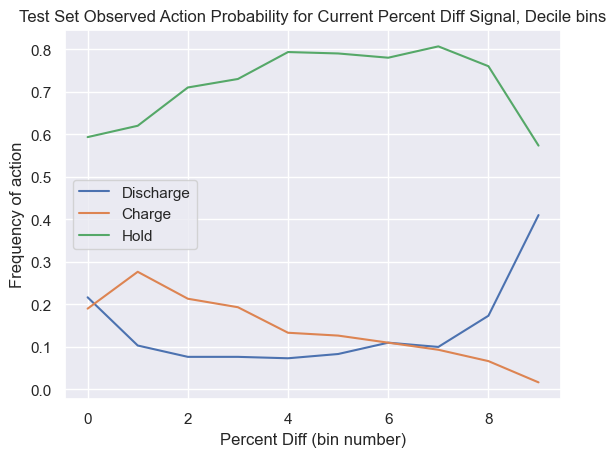

In [156]:
plt.plot(pDischarge, label = 'Discharge')
plt.plot(pCharge, label = 'Charge')
plt.plot(pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Percent Diff Signal, Decile bins")
plt.xlabel('Percent Diff (bin number)')
plt.ylabel('Frequency of action')

In [157]:
np.unique(signal)

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  , 20.  , 40.  , 60.  , 80.  ],
      dtype=float32)

In [168]:
unique, counts = np.unique(signal,return_counts=True)

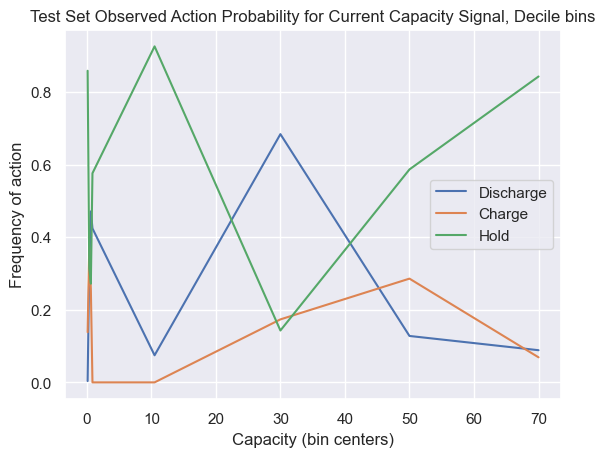

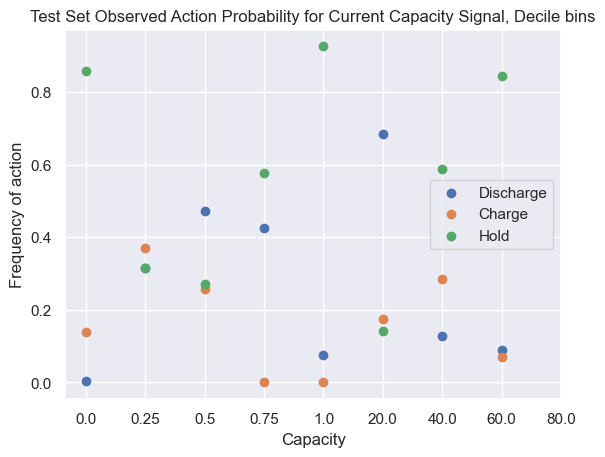

In [180]:
signal = [i[14] for i in obs_list]
signal = np.array(signal)
bin_percentile_size = .01
pDischarge, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==0, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
pCharge, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==1, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
pHold, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==2, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
bin_width = (bin_edges[1:] - bin_edges[:-1])
bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers,pDischarge, label = 'Discharge')
plt.plot(bin_centers,pCharge, label = 'Charge')
plt.plot(bin_centers,pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Capacity Signal, Decile bins")
plt.xlabel('Capacity (bin centers)')
plt.ylabel('Frequency of action')
plt.show()
fig, ax = plt.subplots()
ax.scatter(range(len(pHold)),pDischarge, label = 'Discharge')
ax.scatter(range(len(pHold)),pCharge, label = 'Charge')
ax.scatter(range(len(pHold)),pHold, label = 'Hold')
ax.legend()
ax.set_title("Test Set Observed Action Probability for Current Capacity Signal, Decile bins")
ax.set_xlabel('Capacity')
ax.set_ylabel('Frequency of action')
ax.set_xticks(range(9),labels = np.unique(signal))

In [166]:
counts

array([3, 1, 1, ..., 1, 1, 1], dtype=int64)

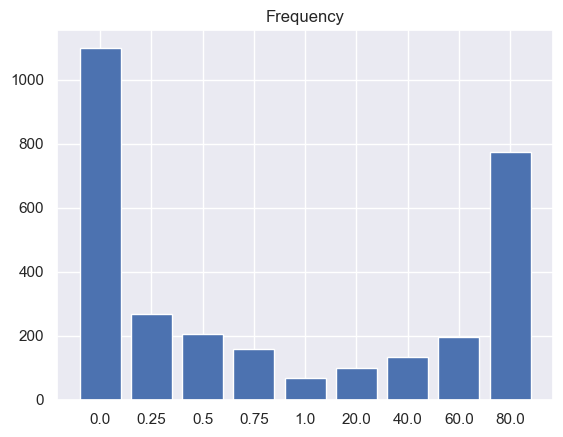

In [178]:
fig, ax = plt.subplots()
ax.bar(range(9), counts)
ax.set_xticks(range(9),labels = np.unique(signal))
plt.title('Frequency')
plt.show()

In [ ]:
pDischarge = []
pCharge = []
pHold = []
for val in np.unique(signal):
    pDischarge.append(np.mean(actions_array[signal == val] ==0))
    pCharge.append(np.mean(actions_array[signal == val] ==1))
    pHold.append(np.mean(actions_array[signal == val] ==2))

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (9).

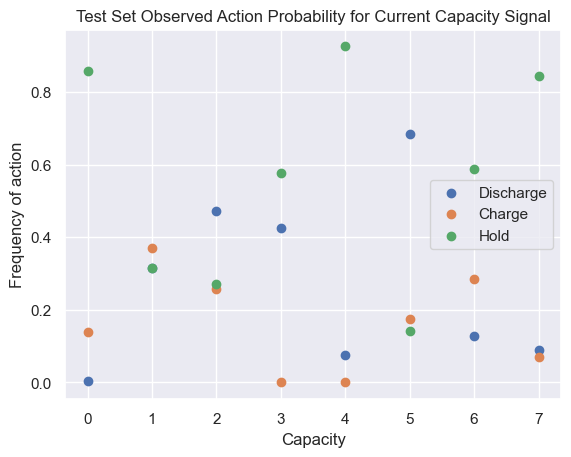

In [160]:
fig, ax = plt.subplots()
ax.scatter(range(len(pHold)),pDischarge, label = 'Discharge')
ax.scatter(range(len(pHold)),pCharge, label = 'Charge')
ax.scatter(range(len(pHold)),pHold, label = 'Hold')
ax.legend()
ax.set_title("Test Set Observed Action Probability for Current Capacity Signal")
ax.set_xlabel('Capacity')
ax.set_ylabel('Frequency of action')
ax.set_xticks(range(len(pHold)),labels = np.unique(signal))

In [161]:
bin_edges

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  , 20.  , 40.  , 60.  , 80.  ],
      dtype=float32)

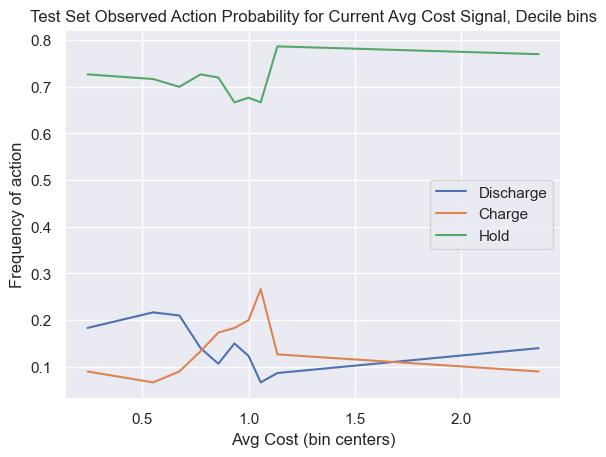

Text(0, 0.5, 'Frequency of action')

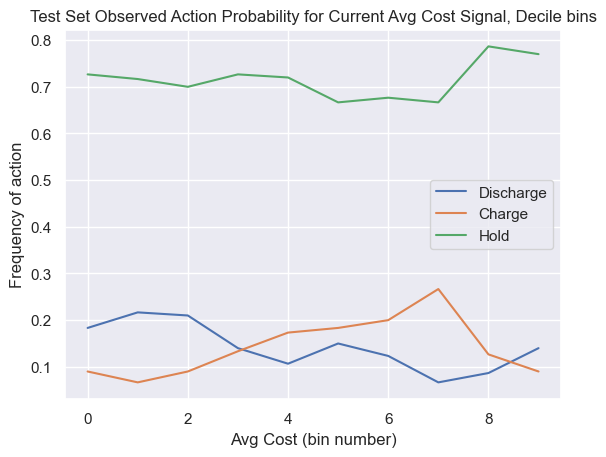

In [162]:
signal = [i[15] for i in obs_list]
signal = np.array(signal)
bin_percentile_size = .1
pDischarge, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==0, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
pCharge, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==1, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
pHold, bin_edges, binnumber = stats.binned_statistic(signal, actions_array ==2, statistic='mean',bins=np.unique(np.quantile(signal,(np.arange(0,1+bin_percentile_size,bin_percentile_size)))))# symlog
bin_width = (bin_edges[1:] - bin_edges[:-1])
bin_centers = bin_edges[1:] - bin_width/2
plt.plot(bin_centers,pDischarge, label = 'Discharge')
plt.plot(bin_centers,pCharge, label = 'Charge')
plt.plot(bin_centers,pHold, label = 'Hold')
plt.legend()
plt.title("Test Set Observed Action Probability for Current Avg Cost Signal, Decile bins")
plt.xlabel('Avg Cost (bin centers)')
plt.ylabel('Frequency of action')
plt.show()
fig, ax = plt.subplots()
ax.plot(pDischarge, label = 'Discharge')
ax.plot(pCharge, label = 'Charge')
ax.plot(pHold, label = 'Hold')
ax.legend()
ax.set_title("Test Set Observed Action Probability for Current Avg Cost Signal, Decile bins")
ax.set_xlabel('Avg Cost (bin number)')
ax.set_ylabel('Frequency of action')


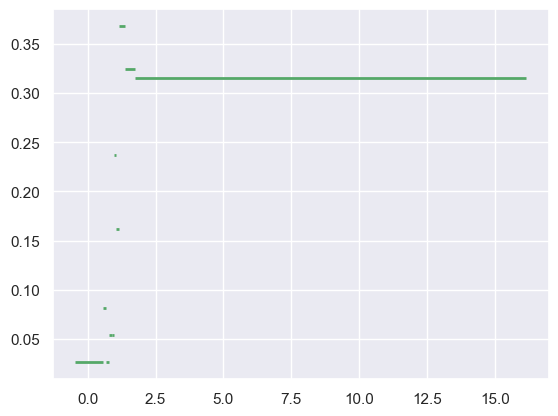

In [86]:
plt.hlines(pDischarge, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,
        label=f'Discharge')# symlog


In [59]:
np.arange(0,1+bin_percentile_size,bin_percentile_size)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [ ]:
def bin(df, column_str, bin_percentile_size = .05):
    """ver npunique"""
    bin_means, bin_edges, binnumber = stats.binned_statistic((df[column_str]), df['PDs'],# symlog
        statistic='mean', bins=np.unique((df[column_str]).quantile(np.arange(0,1+bin_percentile_size,bin_percentile_size))))# symlog
    # bin_means, bin_edges, binnumber = stats.binned_statistic((df[column_str]), df['target_int'],
    #     statistic='mean', bins=(df[column_str]).quantile(np.arange(0,1.05,0.05)))
    bin_width = (bin_edges[1:] - bin_edges[:-1])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_means, bin_centers, bin_width, bin_edges, binnumber


In [ ]:
PPO_power_basic = PPO.load("agents/PPO_power_basic_500k")


### Reward Statistics over 100 Episodes

### Reward Evolution on Held Out Data

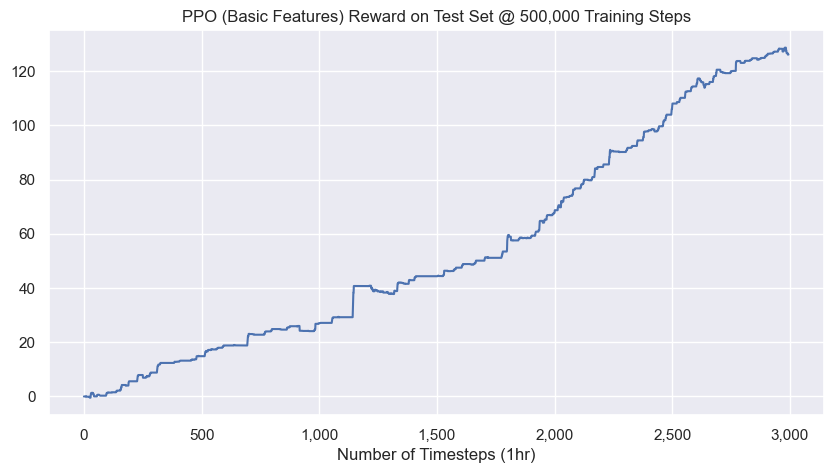

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'x')
ax.plot(history['total_reward'])

plt.title("PPO (Basic Features) Reward on Test Set @ 500,000 Training Steps")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Battery Charge Management

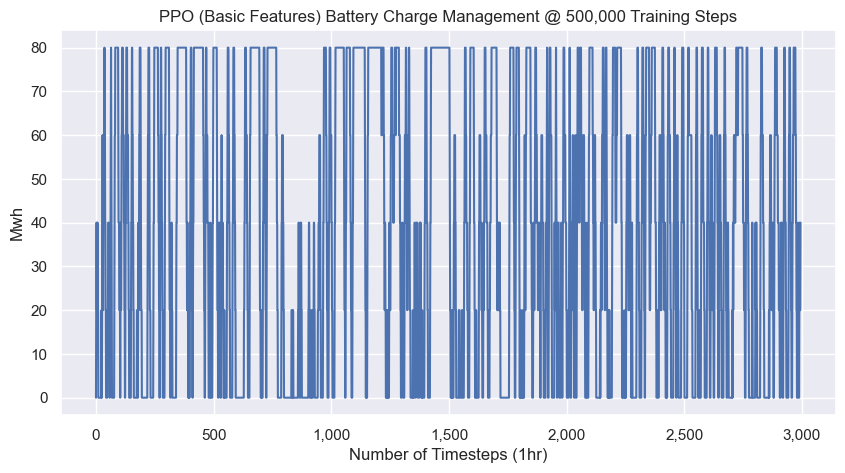

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'x')
ax.plot(history['battery_charge'])

plt.title("PPO (Basic Features) Battery Charge Management @ 500,000 Training Steps")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Profit Evolution on Held Out Data

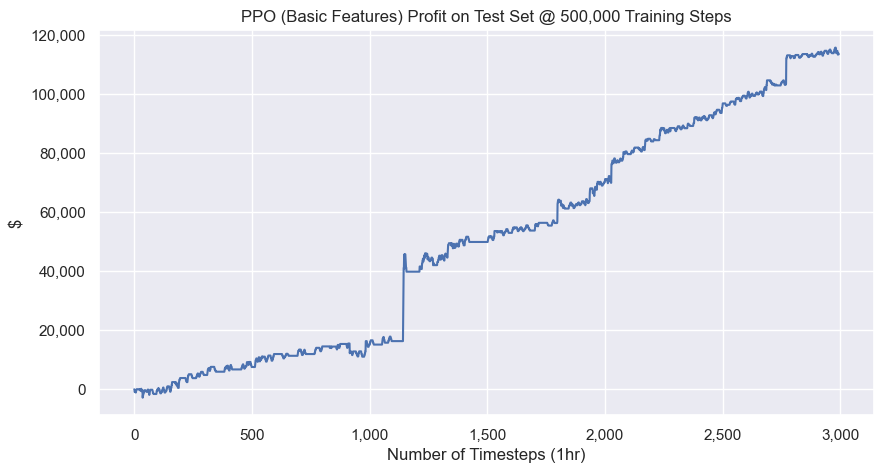

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'y')
format_axis_commas(ax, 'x')
ax.plot(history['total_profit'])

plt.title("PPO (Basic Features) Profit on Test Set @ 500,000 Training Steps")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [ ]:
PPO_power_basic.save('PPO_power_basic_500k')

## PPO Agent with Advanced Features

### (4-hr Observation Window, 552,000 training iterations) 

Environment Observation Comprised of:
-  Current Price (\$/Mwh) 
-  DA Price \($/Mwh)
-  Battery State of Charge (%)
-  Battery Avg Energy Price (\$/Mwh) / Battery Avg Energy Price Window-period Rolling Avg \($/Mwh)

Rewards: 

    - Log Return of profitable discharges: Revenue / Power Sold * Stored Power Cost Basis
    - Log of revenue when selling power with negative cost basis: ln(revenue + |Stored Power Cost Basis|)

Penalty:

    - Overcharging (-1)
    - Discharging When Empty (-1)
    - Losing Money (-1)

In [ ]:
%%time
window = 4 # hours
total_timesteps = 552_000
train_window = 240 # hrs 
n_envs = 4
validation_size = 3000
batch_timesteps = train_window * 1 * n_envs # 1 batch of train_window x window observations for each environment 

# Produce Observations across 16 parallel environments 
venv2 = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=window, frame_bound=(0, train_window)), n_envs=n_envs) 
PPO_power_adv = PPO('MlpPolicy', venv, device='cpu')
logger_adv = VecRewardLogger(verbose=1)

# Walk forward during training to simulate real environment + reduce agent memorization
num_hours = (df.shape[0] - validation_size)
num_eps = num_hours // train_window
num_epochs = total_timesteps // (batch_timesteps * num_eps)

for epoch in range(num_epochs):
    for i in range(num_eps):
        start_day = i * train_window
        end_day = start_day + train_window 
        venv2.env_method('set_frame_bound', start_day, end_day) # Set venvs frame bounds
        # Learn on currrent minibatch
        PPO_power_adv.learn(total_timesteps=batch_timesteps, callback=logger_adv, reset_num_timesteps=False)

### Episode Reward Progression

In [ ]:
num_eps = np.arange(1, len(logger_adv.rewards) + 1)

plt.figure(figsize=(10, 5))
plt.plot(num_eps, logger_adv.rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Agent (Advanced Features) 552,000 Iterations: Episode Reward Progression')
plt.grid(True)
plt.show()

### Plot of Agent Trades in Held out test set

In [ ]:
last_index = len(df) - 10
start_index = last_index - 3000
env2 = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env2.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_adv.predict(obs)
    obs, rewards, term, trunc, info = env2.step(action)
    if term or trunc:
        history = env2.history
        pos = env2.render_all(title="PPO Agent (Advanced) Positions on Test Set @ 552,000 Training Steps", xlim=(1100, 1500))
        env2.reset()

plt.plot()

### Reward Statistics over 100 Episodes

In [ ]:
mean_reward, reward_std = evaluate_policy(PPO_power_adv, env2, n_eval_episodes=100)
print(f"Mean Reward:{ mean_reward:,.2f}\nReward std: {reward_std:,.2f}")

### Reward Evolution on Held Out Data

In [ ]:
plt.plot(history['total_reward'])
plt.title("PPO Agent (Advanced) Reward on Test Set @ 552,000 Training Steps")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Battery Charge Management

In [ ]:
### PPO 10,000 Steps on Sinusoid
plt.plot(history['battery_charge'])
plt.title("PPO Agent Battery Charge (Advanced) Reward on Test Set @ 552,000 Training Steps")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Profit Evolution on Held Out Data

In [ ]:
plt.plot(history['total_profit'])
plt.title("PPO Agent Profit (Advanced) Reward on Test Set @ 552,000 Training Steps")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [ ]:
PPO_power_adv.save('PPO_power_advanced_552k')